# Bootstrapping

## Overnight Index Swap

Interest rate swaps (IRS) are usually used to mitigate the risks od fluctuations of varying interest rates, or to benefit from lower rates. We will always look at these products from the point of view of the **receiver of the floating leg**.

Overnight Index Swaps (OIS) are a particular kind of IRS which pay a floating coupon, determined by overnight rate fixings over the reference periods, against a fixed coupon.  By definition an OIS is defined by:

* a notional amount $N$;
* a starting date $d_0$;
* a sequence of payment dates $d_1,...,d_n$;
* a fixed rate $K$.

For simplicity in the following we are assuming that the fixed and floating legs of our OIS have the same notional and payment dates, although this is not necessarily always the case in practice.

### OIS Valuation
To evaluate the net present value (NPV) of such products the cash flows of each leg have to be calculated; today's NPV then is the sum of all the discounted cash flows.

#### Floating leg
At each payment date, the floating leg pays a cash flow determined as follows:

$$f_{\mathrm{float},~i} = N \Bigg\{\prod_{d=d_{i-1}}^{d=d_i-1}\Big(1+r_{\mathrm{O/N}}(d)\cdot\frac{1}{360}\Big) -1 \Bigg\}$$

Strictly speaking this formula is valid for an EONIA swaps (i.e.~for OIS swaps in EUR) other currencies might have different conventions. The $\frac{1}{360}$ fraction appears because EONIA rates are quoted using the ACT/360 day-count convention. In addition we are making the simplifying assumption of ignoring weekends and holidays, so we assume that each overnight rate is valid for only one day.
The sum of the discounted expected values of these cash flows is

$$\mathrm{NPV}_{\mathrm{float}} = \sum_{i=1}^{n}D(d_i)\mathbb{E}[f_{\mathrm{float},~i}]$$
where $D(d)$ is the discount factor with expiry $d$. On the other hand, by definition (remember Lesson~\ref{calculating-forward-rates} with forward rates), we also have the following relationship

$$\mathbb{E}[f_{\mathrm{float},~i}] = N\cdot\Big(\frac{D_{\mathrm{OIS}}(d_{i-1})}{D_{\mathrm{OIS}}(d_{i})} - 1\Big)$$
hence
$$\mathrm{NPV}_{\mathrm{float}} = N\cdot \sum_{i=1}^{n}D(d_i) \Big(\frac{D_{\mathrm{OIS}}(d_{i-1})}{D_{\mathrm{OIS}}(d_{i})} - 1\Big)$$
where $D_{\mathrm{OIS}}(d)$ is the discount factor implied by OIS prices (we will see how to derive it).

<!----The correct curve to use for discounting the flows of a collateralized contract, like OIS, is the one associated with the collateral. Since OIS contracts are collateralized with cash, and cash accrues daily interest
at the overnight rate, the OIS curve is itself the correct curve with which to discount the flows of an OIS contract ! --->
Since the correct curve to discount OIS is the overnight index itself we have that $D = D_{\mathrm{OIS}}$ so the NPV simplifies to

$$\begin{equation}
  \begin{split}
    \mathrm{NPV}_{\mathrm{float}} & = N\cdot\sum_{i=1}^{n}[D(d_{i-1}) - D(d_i)] =  \\
    &= N\cdot[(D(d_{0}) - D(d_{1})) + (D(d_{1}) - D(d_{2})) + ... + (D(d_{n-1}) - D(d_{n}))]\\
    &= N \cdot [D(d_0) - D(d_n)]
  \end{split}
\end{equation}
$$

#### Fixed leg
The calculation for the fixed leg is simpler; each cash flow is  equal to

$$f_{\mathrm{fix},~i}=N\cdot K\cdot \frac{d_i - d_{i-1}}{360}$$
so the NPV of the fixed leg is

$$\mathrm{NPV}_{\mathrm{fix}} = N\cdot K\cdot \sum_{i=1}^{n}D(d_{i})\frac{d_i - d_{i-1}}{360}$$

### Discount Factor Determination from Market Quotes

Our ultimate goal is to take a series of Overnight Index Swap quotations, and determine the discount factors implied by their prices. To do this we will build a class to represent OIS and compute its value, given particular discount curve. Then we will use this class, put inside a numerical optimizer, to *invert* so that the implied discount factors can be determined from their prices (market quotes).

In [1]:
class OvernightIndexSwap:
    """
    OvernightIndexSwap: a class to valuate Overnight Index Swaps
    
    Attributes:
    -----------
    notional: float
        Notional of the swap.
    payment_dates: list of datetime.date
        List of payment dates of the swap.
    fixed_rate: float
        Rate of the fixed leg of the swap.
    """
    def __init__(self, notional, payment_dates, fixed_rate):
        self.notional = notional
        self.payment_dates = payment_dates
        self.fixed_rate = fixed_rate

    def npv_floating_leg(self, discount_curve):
        """
        npv_floating_leg: computes the floating leg npv.
        
        Params:
        -------
        discount_curve: DiscountCurve
            Discount curve object used for npv calculation.
        """
        return self.notional * (discount_curve.df(self.payment_dates[0]) -
               discount_curve.df(self.payment_dates[-1]))

    def npv_fixed_leg(self, discount_curve):
        """
        npv_fixed_leg: computes the fixed leg npv.
        
        Params:
        -------
        discount_curve: DiscountCurve
            Discount curve object used for npv calculation.
        """
        npv = 0
        for i in range(1, len(self.payment_dates)):
            start_date = self.payment_dates[i-1]
            end_date = self.payment_dates[i]
            tau = (end_date - start_date).days / 360
            df = discount_curve.df(end_date)
            npv = npv + df * tau
            return self.notional * self.fixed_rate * npv
    def npv(self, discount_curve):
        """
        npv: computes the total npv of the swap.
        
        Params:
        -------
        discount_curve: DiscountCurve
            Discount curve object used for npv calculation.        
        """
        float_npv = self.npv_floating_leg(discount_curve)
        fixed_npv = self.npv_fixed_leg(discount_curve)
        return float_npv - fixed_npv

To test the newly developed class we need a discount curve. 
In the following example a fake curve will be defined, and then used with an OIS product.

In [4]:
from datetime import date
from finmarkets import DiscountCurve

ois = OvernightIndexSwap(
            # the notional, one million
            1e6,
            # the list of product dates,
            # i.e. the start date then the payment dates
            [date(2020, 1, 1), date(2020, 4, 1),
             date(2020, 7, 1), date(2020, 10, 1),
             date(2021, 1, 1)],
            # the fixed rate, 2.5%
            0.025)

# fake discount curve
curve = DiscountCurve(date(2020, 1, 1),
                      [date(2020, 1, 1), date(2021, 6, 1),
                       date(2022, 1, 1)],
                      [1.0, 0.98, 0.82])

ois.npv(curve)

-10990.364227052869

## Bootstrapping Technique 

As we said before we would like to determine a *real* discount curve starting from the market quotes of a set of Overnight Index Swaps with different maturities, this will be done via a technique called bootstrapping.
This is the ABC of financial mathematics, since you almost always need a
discount curve to price every contract. We are going to concentrate on EONIA swaps in order to build an EUR discount curve.

### Building OIS Instances
The first step involves getting data, the swap market quotes. This is not quite easy since EONIA swap market is over the counter (OTC) and it’s not straightforward to access it. Anyway in the file ois_data.xlsx it is available 
a data-set of of swap quotes (which actually are rates rather prices) suitable for our needs.
With the help of the $\tt{pandas}$ module the data-set can be inspected:

In [5]:
import pandas, datetime

observation_date = datetime.date.today()
df = pandas.read_excel('ois_data.xlsx')
df.head()

,months,quote
0,1,-0.350
1,2,-0.347
2,3,-0.348
3,4,-0.350
4,5,-0.350


Next we could convert the data-set into a dictionary for later usage or use the $\tt{DataFrame}$ directly, it is just matter of taste.

Let’s say we want to build a 15 months swap instance using data contained in $\tt{ois_data}$ file. Bbe careful when doing this operation and double check the units of rates, quotes, etc...in this case
for example quotes are expressed in percent so you need to multiply them by 0.01 before using them.
Another detail to check is that 15 months quote is not the fifteenth entry in the $\tt{DataFrame}$ (actually it is the twelveth).

In [10]:
ois = OvernightIndexSwap(1e6,
                         [date(2019, 10, 23),
                          date(2020, 10, 23),
                          date(2020, 1, 23)],
                         df['quote'].tolist()[12]*0.01)

# print the last payment date 
# (15 months after obs date)
ois.payment_dates[-1]

datetime.date(2020, 1, 23)

### Bootstrap Algorithm

Keep aside for a moment our swaps and introduce the *bootstrap algorithm*. In finance, bootstrap is a method for constructing a (zero-coupon) fixed-income yield curve from the prices of a set of coupon-bearing products, e.g. bonds and swaps. The term structure of spot returns is obtained from the bond yields by solving for them recursively, by forward substitution: this iterative process is what is called the bootstrap method. 
The usefulness of bootstrap is that using only a few carefully selected zero-coupon products, it becomes possible to derive swap forward and spot rates for all maturities given the solved curve.

To illustrate the algorithm let’s consider the following example which can be solved in part analytically: 
we have some coupon paying bond (coupon of 4\%, 5\%, 6\%, 7\% and 8\% respectively) with
maturities ranging from 1 to 5 years, each having a value of €100 and traded at par. To determine
the zero-coupon yield curve proceed as follows:

* at the end of first year the first bond will pay, so the implied *fair* rate 

$$100 = \cfrac{104}{(1 + S_{1y})}\implies S_{1y} =  104/100 - 1 = 4\%$$

* at the end of second year the sum of the cash flows of the 2nd bond can be compared to its trading price to compute the 2-year spot rate $S_{2y}$ using the previously derived value of $S_{1y}$ 

$$100 = \cfrac{5}{(1 + S_{1y})} + \cfrac{105}{(1 + S_{2y})^{2}}$$

$$\begin{equation*}
\begin{split}
& 100 = 5 / (1 + 0.04) + 105 / (1 + S_{2y})^{2}\qquad\Rightarrow\qquad S_{2y}^2  + 2 S_{2y}  - 0.103030 = 0 \\
& S_{2y} = - 1 \pm \sqrt{1 + 0.103030} = \begin{cases}-2.05023 \\ 0.0503\end{cases}
\end{split}
\end{equation*}$$

From the third year on, still keeping the same reasoning, we obtain equation of third order or more which are not easily analitically solvable. For example following the equation for the fifth bond after five years:

$$100 = \cfrac{8} {(1 + S_{1y})} + \cfrac{8} {(1 + S_{2y})^{2}}+ \cfrac{8} {(1 + S_{3y})^{3}} + \cfrac{8} {(1 + S_{4y})^{4}} + \cfrac{108} {(1 + S_{5y})^{5}}$$

After the substitution of the previously found rates we can however solve it numerically. This can be done like this:

In [9]:
from scipy.optimize import brentq

def func(x):
    return 100 - 8/(1+0.04) - 8/(1+0.0503)**2 - 8/(1+0.0608)**3 - 8/(1+0.0719)**4 - 108/(1+x)**5

a = brentq(func, 0, 0.10)
print ("5y rate: {:.4f}".format(a))

5y rate: 0.0836


The very same mechanism can be generalized and extended to more maturities to get a more detailed yield curve. In general terms the previous system can be written as:

$$\begin{equation*}
\begin{cases}
f_1(S_1, p_1) = 0 \\
f_2(S_1, S_2, p_2) = 0 \\
f_3(S_1, S_2, S_3, p_3) = 0 \\
f_4(S_1, S_2, S_3, S_4, p_4) = 0 \\
\cdots
\end{cases}
\end{equation*}
$$
where $S_i$ are the unknown spot rates and $p_i$ the market quotes of the considered products. The iterative procedure we have applied before exploits the first equation to find $S_1 = $f_1^{-1}(p_1)$, the second to find $S_2 = f_2^{-1}(S_1, p_2)$ and so on and so forth.
This algorithm works since each equation will determine exactly one free spot rate which is not already determined by the others.

### Bootstrap as Minimization Problem
Instead of iteratively finding the solution of each equation as before, equivalently we could define a vector of spot rates $\mathbf{S} = (S_1, S_2, S_3,\ldots)$ seeking for a particular $\mathbf{\hat{S}}$ which solves the following equation:

$$F = f_1^2(S_1) + f_2^2(S_1, S_2) + f_3^2(S_1, S_2, S_3) + f_4^2(S_1, S_2, S_3, S_4) + \ldots = 0$$

Under this terms the bootstrap technique can be considered as a minimization problem indeed we need to find $\mathbf{\hat{S}}$ which \emph{minimize} $F$, or at least makes it as close as possible to 0.
Each $f_i$ is squared since we want all of them to be minimized and not only $F$ globally (without the squared there may be cancellation effects between the terms of the sum).

### OIS Example
Back to our Overnight Index Swap, the general idea here is to find the discount curve $\mathcal{C}$ such that it prices as much correctly as possible each OIS by minimizing the sum of the squared OIS NPVs (our $f_i$):

$$\mathrm{min}_{\mathcal{C}} \Big\{\sum_{i=1}^{n}\mathrm{NPV}(\mathrm{OIS}_i, \mathcal{C})^2\Big\}$$

A discount curve is characterized by pillar dates and the corresponding discount factors. The description of the problem we have given above does not, in theory, specifies any constraint on the pillar dates of the discount curve $\mathcal{C}$ we are going to find.
However, the pillar dates determine the number of unknown variables (i.e.~the dimensionality \(N\) of the optimization problem). A curve with \(N\) pillar dates has also \(N\) discount factors (note that the first discount factor with value date equal to the today date, is constrained to 1). **In practice, therefore, it makes sense to choose the pillar dates in such a way that there are exactly the right number of degrees of freedom in the optimization to match data.** So the natural choice is to choose the pillar dates of the discount curve equal to the set of expiry dates of the swaps.

Therefore, once we've fixed $\mathbf{d}$ to be a vector of pillar dates equal to the expiry dates of the OIS swaps, and we use the notation $\mathbf{x}$ to represent the vector of unknown pillar discount factors, then the problem becomes:

$$\mathrm{min}_{\mathbf{x}} \Big\{\sum_{i=1}^{N}\mathrm{NPV}(\mathrm{OIS}_i, \mathcal{C}(\mathbf{d}, \mathbf{x}))^2\Big\}$$
which is our optimization problem (**to find the minimum of the above expression as a function of x**) which can be solved using one of the available numerical optimization routines in $\tt{python}$.

So first let's create the swaps according to all the available market quotes and also the pillar dates of our final discount curve:

In [12]:
from finmarkets import generate_swap_dates

observation_date = date(2019, 10, 23)
pillar_dates = [observation_date]
swaps = [] # container of the OIS objects

for i in range(len(df)):
    swap = OvernightIndexSwap(1e6,
                    generate_swap_dates(
                        observation_date, 
                        df['months'].tolist()[i]),
                    0.01 * df['quote'].tolist()[i])

    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])

# this shouldn't be necessary if the original
# list of market quotes is sorted
pillar_dates = sorted(pillar_dates)

### Minimization Algorithm

A minimization algorithm follows these steps:

* define an *objective function* i.e. the function that is actually minimized to reach our goal;
* set the initial value of the unknown parameters and their range of variability;
* the minimizer will compute the objective function value;
* then it will move the parameter values in such a way to find a smaller value of the objective function (e.g. following the derivative w.r.t. each parameter);
* the last two steps will be repeated until further variations of the $\mathbf{x}$ values won’t change significantly the objective function (i.e. we have found a minimum of the function so the minimisation process is completed !).

So implement the method to the swaps we have just created.

* define the objective function: the sum of the squared NPVs of the OIS 

In [13]:
def objective_function(x):
    curve = DiscountCurve(observation_date,
                          pillar_dates,
                          x)
    
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
    return sum_sq

* set the initial value of the discount factors ($x_i$) to 1 with a range of variability $[ 0.01, 10]$, in addition the first element of the list, today’s discount factor, will be fixed to 1 (variability $[1, 1]$)

In [14]:
x0 = [1.0 for i in range(len(pillar_dates))]

bounds = [(0.01, 10.0) for i in range(len(pillar_dates))]
bounds[0] = (1.0, 1.0)

* finally we can launch the minimizer to find the discount factors ($x$)

In [16]:
from scipy.optimize import minimize

result = minimize(objective_function, x0, bounds=bounds)
print (result)

      fun: 0.000819919032900304
 hess_inv: <34x34 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.58948735e+05, -1.58720803e+01, -6.53143264e+01, -1.03323232e+02,
       -1.26050260e+02, -1.31748898e+02, -1.20374599e+02, -9.15399651e+01,
       -4.24363322e+01,  2.44903182e+01,  1.14345243e+02,  2.22002243e+02,
       -3.72021700e+00,  4.21398633e+01,  4.21787852e+01,  4.22369487e+01,
        4.23327026e+01,  4.31814758e+01,  4.44924460e+01,  4.62078978e+01,
        4.82906823e+01, -3.69972738e+00, -1.42454702e+00,  7.53771932e-01,
        2.79741018e+00,  4.62896699e+00,  6.24844054e+00,  9.93101553e+00,
        1.31122434e+01,  1.42880909e+01,  1.48279215e+01,  1.50787019e+01,
        1.43267935e+01,  1.38451324e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 840
      nit: 7
   status: 0
  success: True
        x: array([1.        , 1.00030147, 1.00058831, 1.00089012, 1.00119726,
       1.00147996, 1.00178743, 1.00208107, 1.00238467, 1.002

Some diagnostic number/plot.

In [18]:
print ("Initial objective function value ", objective_function(x0))
print ("Final objective function value ", objective_function(result.x))

Initial objective function value  931188216.6666666
Final objective function value  0.000819919032900304


<img src="obj_func.png" width=600>
<img src="obj_func_iter.png" width=600>

Finally we can create the discount curve implied by the market quote of our swaps. 

In [21]:
from math import log
curve = DiscountCurve(observation_date, pillar_dates, result.x)

d = date(2059, 11, 23)
print ("40y df: {}".format(curve.df(d)))
print ("40y rate: {}".format(-log(curve.df(d)) / 40))             

40y df: 0.9891780176191146
40y rate: 0.0002720241491103593


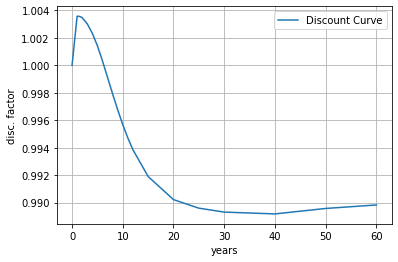

In [30]:
from matplotlib import pyplot as plt

dates = [(d-observation_date).days/365. for d in curve.pillar_dates]
plt.plot(dates, result.x, label="Discount Curve")
plt.grid(True)
plt.xlabel("years")
plt.ylabel("disc. factor")
plt.legend()
plt.show()